In [ ]:
import ee # earth engine 
try: 
    ee.Initialize(project = "uhi-project-2025")
    print("Earth Engine was initialized successfully")
except Exception as e: 
    print(f"Earth Engine initialization failed: {e}")

# define the interest area (Bucharest's approximate center and 10 km around it as a circle)
roi = ee.Geometry.Point([26.1, 44.43]).buffer(10000) 
# The data we are getting is based of Google Earth Engine tiff images
# (.tiff images are raster-format-based pictures that store values for any pixel. The values can represent temperatures, heights etc.,
# basically measurable units)

# the dataype we are working with is ee.Image -> a set of bands which, conceptually, are 2D matrices
# each band has a meaning: e.g. For Landsat 8 (which we'll be using, there are multiple bands. the 10th and 11th are 
# thermal bands). 

# our goal, first... to get a collection of tiff images from Google Earth Engine. 
# for that, we need to do some conversions. 

# 1. Calculate the LST. (Land Surface Temperature); It helps us to determine
# the labels for our model. Based on the temperature, we'll be having 3 labels: cold, moderate, hot. 
def add_lst_c(image: ee.Image):
    lst_k = image.select('ST_B10').multiply(0.00341802).add(149.0)
    lst_c = lst_k.subtract(273.15).rename('LST_C')
    return image.addBands(lst_c)

def safe_number(stats, key, default):
    return ee.Number(ee.Algorithms.If(stats.contains(key), stats.get(key), default))

# 2. Define the Urban Heat Island labels 
def label_uhi_3_classes(image: ee.Image):
    """Label UHI in 3 classes: 0=cold, 1=moderate, 2=hot, using multi-indices"""
    lst = image.select('LST_C')
    ndvi = image.select('NDVI')
    ndbi = image.select('NDBI')
    mndwi = image.select('MNDWI')
    brightness = image.select('BRIGHTNESS')

    qa = image.select('QA_PIXEL')
    cloud_bit = 1 << 3
    shadow_bit = 1 << 4
    cloud_mask = qa.bitwiseAnd(cloud_bit).neq(0)
    shadow_mask = qa.bitwiseAnd(shadow_bit).neq(0)
    invalid_pixels = cloud_mask.Or(shadow_mask)

    region_stats = image.select(['LST_C','NDVI','NDBI','MNDWI']).updateMask(invalid_pixels.Not()).reduceRegion(
        reducer=ee.Reducer.percentile([20,40,60,80]),
        geometry=image.geometry(),
        scale=30,
        maxPixels=1e9,
        tileScale=4
    )

    # use percentiles 
    lst_p20 = safe_number(region_stats,'LST_C_p20',15)
    lst_p40 = safe_number(region_stats,'LST_C_p40',20)
    lst_p60 = safe_number(region_stats,'LST_C_p60',25)
    lst_p80 = safe_number(region_stats,'LST_C_p80',30)

    ndvi_p20 = safe_number(region_stats,'NDVI_p20',0.1)
    ndvi_p40 = safe_number(region_stats,'NDVI_p40',0.25)
    ndvi_p60 = safe_number(region_stats,'NDVI_p60',0.4)
    ndvi_p80 = safe_number(region_stats,'NDVI_p80',0.65)
    ndbi_p20 = safe_number(region_stats,'NDBI_p20',-0.1)
    ndbi_p40 = safe_number(region_stats,'NDBI_p40',0.0)
    ndbi_p60 = safe_number(region_stats,'NDBI_p60',0.15)
    ndbi_p80 = safe_number(region_stats,'NDBI_p80',0.3)
    
    mndwi_p20 = safe_number(region_stats,'MNDWI_p20',-0.2)
    mndwi_p40 = safe_number(region_stats,'MNDWI_p40',-0.1)
    mndwi_p60 = safe_number(region_stats,'MNDWI_p60',0.0)
    mndwi_p80 = safe_number(region_stats,'MNDWI_p80',0.2)

    # cold zones
    water_zones = mndwi.gt(0.2).And(ndvi.lt(0.3))
    dense_vegetation = ndvi.gt(ndvi_p80.multiply(0.85)).And(ndbi.lt(ndbi_p40)).And(lst.lt(lst_p60.add(5)))
    cool_natural = lst.lt(lst_p40).And(ndvi.gt(ndvi_p40)).And(ndbi.lt(ndbi_p60))
    cold_zones = water_zones.Or(dense_vegetation).Or(cool_natural).Or(invalid_pixels)

    # hot zones
    hot_uhi = lst.gt(lst_p60.add(3)).And(ndbi.gt(ndbi_p60)).And(ndvi.lt(ndvi_p40)).And(mndwi.lt(0))
    very_hot = lst.gt(lst_p80.subtract(2)).And(ndbi.gt(ndbi_p40)).And(ndvi.lt(ndvi_p60))
    dense_urban = ndbi.gt(ndbi_p80.multiply(0.9)).And(ndvi.lt(ndvi_p20.multiply(1.5))).And(brightness.gt(0.2)).And(lst.gt(lst_p40))
    hot_zones = hot_uhi.Or(very_hot).Or(dense_urban)

    # moderate zones
    moderate_zones = cold_zones.Not().And(hot_zones.Not())

    # combine
    label_map = ee.Image(1).where(cold_zones,0).where(hot_zones,2).where(moderate_zones,1).rename('label')
    return image.addBands(label_map)

# 3. Mask the clouds and the shadows (the model might count them as "cold" areas, which will not be 100% correct). 
def mask_l8_l2(image: ee.Image):
    qa = image.select('QA_PIXEL')

    # multiple cloud detection flags 
    cloud = qa.bitwiseAnd(1<<3).eq(0) # cloud confidence
    cloud_shadow = qa.bitwiseAnd(1<<4).eq(0)  # cloud shadow confidence
    cirrus = qa.bitwiseAnd(1<<2).eq(0) # cirrus confidence
    dilated_cloud = qa.bitwiseAnd(1<<1).eq(0) # dilated cloud

    # additional spectral-based cloud detection
    blue = image.select('SR_B2').multiply(0.0000275).add(-0.2)
    red = image.select('SR_B4').multiply(0.0000275).add(-0.2)
    nir = image.select('SR_B5').multiply(0.0000275).add(-0.2)

    # additional spectral-based cloud detection
    ndvi = nir.subtract(red).divide(nir.add(red))
    spectral_cloud = blue.gt(0.2).And(ndvi.lt(0.2))

    # combine all cloud masks
    mask = cloud.And(cloud_shadow).And(cirrus).And(dilated_cloud).And(spectral_cloud.Not())
    return image.updateMask(mask)

# 4. Scale the data
def scale_sr(image: ee.Image):
    sr = image.select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']).multiply(0.0000275).add(-0.2).rename(['Blue','Green','Red','NIR','SWIR1','SWIR2'])
    return image.addBands(sr,overwrite=True)


# 5. Calculate indices related to vegetation(NDVI), areas with buildings(NDBI), water areas(MNDWI)
def add_indices(image: ee.Image):
    green = image.select('Green')
    blue = image.select('Blue')
    red = image.select('Red')

    nir = image.select('NIR') # Near Infrared -> vegetation reflects better in it
    swir1 = image.select('SWIR1') # Short Wave Infrared -> construction zones reflect better in it
    swir2 = image.select('SWIR2')

    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    ndbi = swir1.subtract(nir).divide(swir1.add(nir)).rename('NDBI')
    mndwi = green.subtract(swir1).divide(green.add(swir1)).rename('MNDWI')

    #other indices for urban areas
    bei = swir1.subtract(red).divide(swir1.add(red)).rename('BEI') # built-up enhanced index
    ui = swir2.subtract(nir).divide(swir2.add(nir)).rename('UI') # urban index, ndbi-like
    brightness = (blue.add(green).add(red).add(nir).add(swir1).add(swir2)).divide(6).rename('BRIGHTNESS')

    return image.addBands([ndvi,ndbi,mndwi,bei,ui,brightness])


# Get the Landsat ee.Image items collection
collection = (ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
            .filterBounds(roi) # inside our area of interest
            .filterDate('2025-06-01', '2025-08-31') 
            .filter(ee.Filter.lt('CLOUD_COVER', 20))
            .map(mask_l8_l2) # applies the method defined before on EACH image of the collection
            .map(scale_sr)
            .map(add_lst_c)
            .map(add_indices)
            .map(label_uhi_3_classes) 
            )

print(f"The number of images obtained: {collection.size().getInfo()}") # fetch the data from 
# the server to the local notebook :D

# We now need to export the features and the labels for our future model
def export_image(image: ee.Image, folder_name: str = "UHI_dataset"): 
    # save the images in the format: feature/label_{date}.tiff
    date_string = image.date().format('YYYYMMdd').getInfo()
    bands_to_export = [
        'Blue', 'Green', 'Red', 'LST_C', 'NIR', 'SWIR1', 'SWIR2', 
        'NDVI', 'NDBI', 'MNDWI', 'BEI', 'UI', 'BRIGHTNESS'
    ] 
    
    task1 = ee.batch.Export.image.toDrive(
        image = image.select(bands_to_export), 
        description = f"features_{date_string}",
        maxPixels = 1e13, 
        region = roi, 
        fileNamePrefix = f"features_{date_string}", 
        folder = folder_name, 
        scale = 30 # resolution in meters (30m is default for Landsat btw)
    )
    task1.start() 

    task2 = ee.batch.Export.image.toDrive(
        folder = folder_name, 
        fileNamePrefix = f"labels_{date_string}", 
        description = f"labels_{date_string}", 
        maxPixels = 1e13,
        scale = 30, 
        region = roi,
        image = image.select(['label'])  
    )
    task2.start()

# run for a sample of 5 images let's say
images_list = collection.toList(collection.size())
for i in range(min(5, collection.size().getInfo())): 
    export_image(ee.Image(images_list.get(i)))

    # .get() returns a proxy -> cast it into ee.Image to obtain the desired image 

print("Exports started. Check Google Drive after some time :).")

Earth Engine was initialized successfully
The number of images obtained: 10
Exports started. Check Google Drive after some time :).


('Blue', 'Green', 'Red', 'LST_C', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NDBI', 'MNDWI', 'BEI', 'UI', 'BRIGHTNESS')


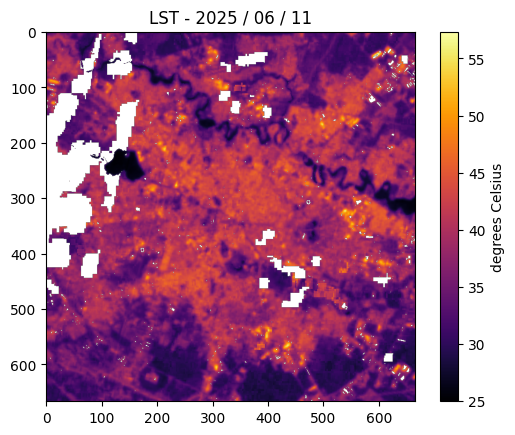

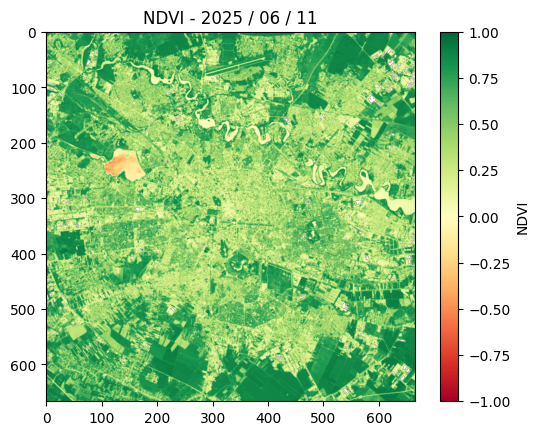

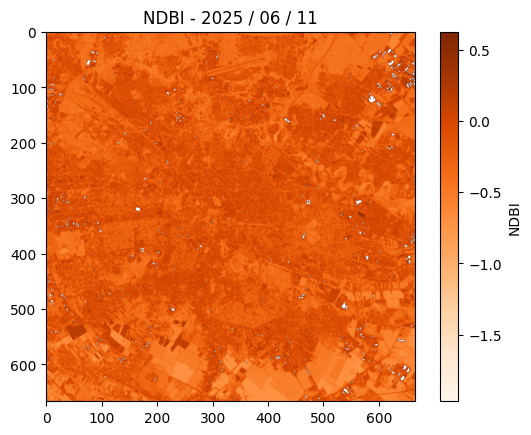

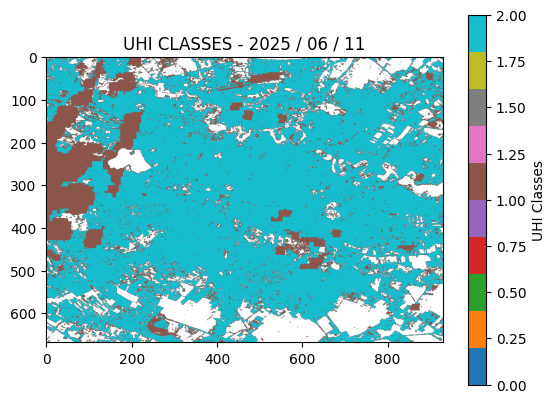

In [141]:
import rasterio
import matplotlib.pyplot as plt 
import numpy as np

with rasterio.open("assets/features_20250602.tif") as src: 
    print(src.descriptions) #- ('Blue', 'Green', 'Red', 'LST_C', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NDBI', 'MNDWI', 'BEI', 'UI', 'BRIGHTNESS')
                              # - 0         1        2     3      4         5         6       7       8       9     10     11       12
    feature = src.read()

lst_feature = feature[3]
plt.imshow(lst_feature, cmap = 'inferno')
plt.title('LST - 2025 / 06 / 11')
plt.colorbar(label = "degrees Celsius")
plt.show()

ndvi_feature = feature[7]
plt.imshow(ndvi_feature, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label = 'NDVI')
plt.title("NDVI - 2025 / 06 / 11")
plt.show()

ndbi_feature = feature[8]
plt.imshow(ndbi_feature, cmap = 'Oranges')
plt.colorbar(label = 'NDBI')
plt.title('NDBI - 2025 / 06 / 11')
plt.show()

with rasterio.open('assets/labels_20250602.tif') as src: 
    label = src.read(1)

label_masked = np.where(label == 0, np.nan, label)
#                       condition   value if true value if false
plt.imshow(label_masked, cmap = 'tab10', vmin = 0, vmax = 2)
plt.title('UHI CLASSES - 2025 / 06 / 11')
plt.colorbar(label = 'UHI Classes')
plt.show()

In [143]:
import rasterio 
from sklearn.feature_extraction import image as skimage
import numpy as np 

images = ["assets/features_20250602.tif", "assets/features_20250627.tif", "assets/features_20250713.tif", "assets/features_20250814.tif", "assets/features_20250830.tif",
          "assets/labels_20250602.tif", "assets/labels_20250627.tif", "assets/labels_20250713.tif", "assets/labels_20250814.tif", "assets/labels_20250830.tif"]

features = []
for image in images[:5]:
    try:  
        with rasterio.open(image) as src: 
            features_img = src.read() 

        features.append(features_img)
        print(f"Loaded {image}")
    except FileNotFoundError: 
        print(f"File not found {image}")
        
for i, f in enumerate(features):
    print(f"Image {i} shape: {f.shape}")
features_stacked = np.stack(features)

labels = []
for image in images[5:]: 
    try: 
        with rasterio.open(image) as src: 
            labels_img = src.read()
        labels.append(labels_img)
        print(f'Loaded {image}')
    except FileNotFoundError: 
        print(f"File not found {image}")

labels_stacked = np.stack(labels)

# cleaning the data 

features_clean = np.nan_to_num(features_stacked, nan = 0.0)
labels_clean = np.nan_to_num(labels_stacked, nan = 0.0)
print("Data cleaned, the Nan values were replaced")


def extract_patches_multichannel(img, patch_size=(64,64), max_patches = 6000, overlap = 0.5):
    """ Divides each image into overlapping patches of a certain resolution."""
    # img: num_bands, height, width
    C, H, W = img.shape

    patches = []
    positions = [] 
    step = int(patch_size * (1 - overlap))

    for i in range(0, H - patch_size + 1, step): 
        for j in range(0, W - patch_size + 1, step): 
            patch = img[:, i : i + patch_size, j : j + patch_size] #all channels, patch_size x patch_size dimension

            # filter the patch that has too many zeros / invalid values 
            valid_ratio = np.sum(patch != 0) / (C * patch_size * patch_size) # total number of patches. 
            if valid_ratio > 0.7: # at least 70% of pixels are valid
                patches.append(patch)
                positions.append((i,j))

            # exit if the maximum number of patches is reached 
            if len(patches) >= max_patches:
                break
        if len(patches) >= max_patches: 
            break 

    return np.array(patches), positions

print("Extracting the patches...")

patch_size = 64
max_patches = 6000

all_features_patches = []
all_labels_patches = []

for i, (feature_img, label_img) in enumerate(zip(features_clean, labels_clean)): 
    feature_patches, positions = extract_patches_multichannel(feature_img, patch_size, max_patches, overlap = 0.3)

    label_patches = []
    for pos in positions: 
        i_pos, j_pos = pos
        label_patch = label_img[0, i_pos:i_pos + patch_size, j_pos:j_pos + patch_size]
        label_patches.append(label_patch)

    all_features_patches.extend(feature_patches)
    all_labels_patches.extend(label_patches)

    print(f'Extracted {len(feature_patches)} patches from image {i + 1}')

# convert all patches and labels to numpy arrays 
all_labels_patches = np.array(all_labels_patches)
all_features_patches = np.array(all_features_patches)

print(f"Total features patches extracted : {len(all_features_patches)}")
print(f"Total labels patches extracted : {len(all_labels_patches)}")
print(f"Feature patches shape: {feature_patches.shape}")

Loaded assets/features_20250602.tif
Loaded assets/features_20250627.tif
Loaded assets/features_20250713.tif
Loaded assets/features_20250814.tif
Loaded assets/features_20250830.tif
Image 0 shape: (13, 667, 666)
Image 1 shape: (13, 667, 666)
Image 2 shape: (13, 667, 666)
Image 3 shape: (13, 667, 666)
Image 4 shape: (13, 667, 666)
Loaded assets/labels_20250602.tif
Loaded assets/labels_20250627.tif
Loaded assets/labels_20250713.tif
Loaded assets/labels_20250814.tif
Loaded assets/labels_20250830.tif
Data cleaned, the Nan values were replaced
Extracting the patches...
Extracted 196 patches from image 1
Extracted 196 patches from image 2
Extracted 196 patches from image 3
Extracted 196 patches from image 4
Extracted 196 patches from image 5
Total features patches extracted : 980
Total labels patches extracted : 980
Feature patches shape: (196, 13, 64, 64)


In [54]:
print(type(all_features_patches))

<class 'numpy.ndarray'>


In [55]:
type(all_labels_patches)
print(all_labels_patches.shape) # 980 patches, each having a resolution of 64 x 64 

(980, 64, 64)


In [145]:
class UHIAugumentation: 
    def __init__(self, prob = 0.5): 
        self.probability = prob
    
    def __call__(self, feature_patch, label_patch): 
        if np.random.random() < self.probability: 
            # perform random rotation
            k = np.random.choice([1,2,3]) # 1 -> 90, 2 -> 180, 3 -> 270
            feature_patch = np.rot90(feature_patch, k, axes = (1,2)) # feature patch has shape (C, H, W) -> modify the H and W placement
            label_patch = np.rot90(label_patch, k) # label is only 2-dimensional

        if np.random.random() < self.probability: 
            # perform random flip 
            if np.random.random() < 0.5: 
                feature_patch = np.flip(feature_patch, axis = 1)
                label_patch = np.flip(label_patch, axis = 0)
            else: 
                feature_patch = np.flip(feature_patch, axis = 2)
                label_patch = np.flip(label_patch, axis = 1)

        return feature_patch, label_patch
    
# apply augumentation 
print("Applying data augumentation -> obtaining more data")

augumentation = UHIAugumentation(prob = 0.3)

augumented_features = []
augumented_labels = []

for feature, label in zip(all_features_patches, all_labels_patches):
    augumented_feature, augumented_label = augumentation(feature, label)
    augumented_features.append(augumented_feature)
    augumented_labels.append(augumented_label)
    
# merge all data into one 
final_features = np.concatenate([all_features_patches, augumented_features])
final_labels = np.concatenate([all_labels_patches, augumented_labels])

print(f"Final dataset size: {len(final_features)} patches") # 1960 patches. 

Applying data augumentation -> obtaining more data
Final dataset size: 1960 patches


In [146]:
# convert numpy arrays into torch tensors 

import torch 
final_features = torch.from_numpy(final_features).float()
final_labels = torch.from_numpy(final_labels).long()
print(type(final_features)) # -> torch.Tensor. 
print(f"Shape of features: {final_features.shape}")

<class 'torch.Tensor'>
Shape of features: torch.Size([1960, 13, 64, 64])


In [58]:
final_features.dtype # should be float32 

torch.float32

In [147]:
# convert the tensor patches into datasets
from torch.utils.data import TensorDataset
dataset = TensorDataset(final_features, final_labels)

train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
validation_size = len(dataset) - train_size - test_size

print(f"There are {test_size} samples for testing")
print(f"There are {train_size} samples for training")
print(f"There are {validation_size} samples for validation")

There are 196 samples for testing
There are 1568 samples for training
There are 196 samples for validation


In [148]:
from torch.utils.data import random_split
train_dataset, validation_dataset, test_dataset = random_split(
    dataset, [train_size, validation_size, test_size]
)

print(len(train_dataset)) # it matches the train_size. 
print(f"For patch number 1254, the input data shape is {train_dataset[1253][0].shape} and the label associated shape is {train_dataset[1253][1].shape}")

1568
For patch number 1254, the input data shape is torch.Size([13, 64, 64]) and the label associated shape is torch.Size([64, 64])


In [149]:
# convert the datasets into dataloaders - which are iterables 
from torch.utils.data import DataLoader

torch.manual_seed(42)
BATCH_SIZE = 16 # compute the data into batches. 
# a single batch groups n different samples into one "package" -> this will lead to
# faster computation, better results 

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, # it is considered good practice to shuffle the train data
                              num_workers = 2) # runs data on 2 parallel processes

validation_dataloader = DataLoader(dataset = validation_dataset, 
                                   batch_size = BATCH_SIZE, 
                                   shuffle = False, 
                                   num_workers = 2)

test_dataloader = DataLoader(dataset = test_dataset, 
                             batch_size = BATCH_SIZE, 
                             shuffle = False, 
                             num_workers = 2)


In [150]:
# check the outputs 
print(f"There are {len(train_dataloader)} training batches, each having {BATCH_SIZE} samples.")
print(f"There are {len(test_dataloader)} testing batches, each having {BATCH_SIZE} samples")
print(f"There are {len(validation_dataloader)} validation batches, each having {BATCH_SIZE} samples")

There are 98 training batches, each having 16 samples.
There are 13 testing batches, each having 16 samples
There are 13 validation batches, each having 16 samples


In [151]:
# see a sample from the dataloader 
image_batch, label_batch = next(iter(test_dataloader))
image_batch.shape # torch.Size([16, 10, 64, 64]) -> 16 samples, 10 channels, each patch is 64 x 64. Great!

torch.Size([16, 13, 64, 64])

Text(0.5, 1.0, 'Display random sample')

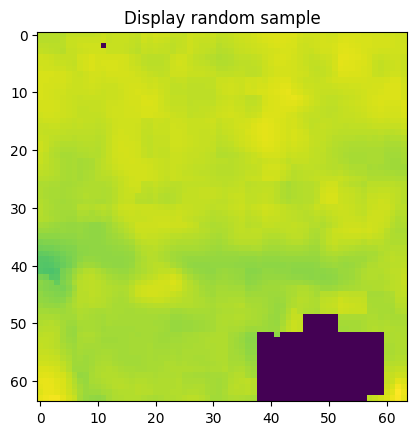

In [152]:
import matplotlib.pyplot as plt
random_idx = torch.randint(0, len(image_batch), size = [1]).item()
img, label = image_batch[random_idx], label_batch[random_idx]

plt.imshow(img[3])
plt.title("Display random sample")


In [154]:
from torch import nn

class UHINet(nn.Module):
    def __init__(self, input_shape: int = 13, output_shape: int = 3, hidden_units: int = 32):
        """
        input_shape: number of channels for an image(Blue, Red, Green, NIR, NDVI, NDBI, MNDWI) 
        output_shape: number of classes (cold, moderate, hot)
        """
        super().__init__()

        # Encoder - reduces the dimension and extracts features
        self.encoder1 = self._make_encoder_block(input_shape, hidden_units)
        self.encoder2 = self._make_encoder_block(hidden_units, hidden_units*2)
        self.encoder3 = self._make_encoder_block(hidden_units*2, hidden_units*4)

        # Bottleneck - extra filters for more complex features
        self.bottleneck = nn.Sequential(
            nn.Conv2d(hidden_units*4, hidden_units*8, 3, padding=1),
            nn.BatchNorm2d(hidden_units*8),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3)
        )

        self.attention = SpatialAttention(hidden_units*8)
        
        # Decoder - reconstruction for the image
        self.decoder3 = self._make_decoder_block(hidden_units*8, hidden_units*4)
        self.decoder2 = self._make_decoder_block(hidden_units*8, hidden_units*2)  # *8 due to skip connection
        self.decoder1 = self._make_decoder_block(hidden_units*4, hidden_units)
        
        # classification layer 
        self.final_conv = nn.Sequential(
            nn.Conv2d(hidden_units*2, hidden_units, 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_units, output_shape, 1),
            nn.Dropout2d(0.1)
        )

    def forward(self, x):
        # Encoder path with skip connections
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(torch.nn.functional.max_pool2d(enc1, 2))
        enc3 = self.encoder3(torch.nn.functional.max_pool2d(enc2, 2))
        
        # Bottleneck with attention
        bottleneck = self.bottleneck(torch.nn.functional.max_pool2d(enc3, 2))
        bottleneck = self.attention(bottleneck)
        
        # Decoder path with skip connections
        dec3 = self.decoder3(bottleneck)
        dec3 = torch.cat([dec3, enc3], dim=1)
        
        dec2 = self.decoder2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        
        dec1 = self.decoder1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        
        # Final output
        output = self.final_conv(dec1)
        return output
    
    def _make_encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _make_decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
class SpatialAttention(nn.Module): 
    """ Spatial attention mechanism"""
    def __init__(self, in_channels): 
        super().__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, 1),
            nn.ReLU(inplace = True), 
            nn.Conv2d(in_channels // 4, 1, 1), 
            nn.Sigmoid()
        )

    def forward(self, x): 
        att_weights = self.attention(x)
        return x * att_weights
    

In [155]:
# create an instance of the model 
model_0 = UHINet(input_shape = final_features.shape[1], 
                 output_shape = 3, 
                 hidden_units = 32)

# do a forward pass with some random data 
dummy_tensor = torch.rand([1,13,64,64])
model_0(dummy_tensor)

tensor([[[[-0.7734, -0.8942, -0.6529,  ..., -0.5999, -0.8300, -0.6356],
          [-1.0691, -0.4311, -0.7535,  ..., -0.5035, -0.1086, -0.1593],
          [-0.7359, -0.4407,  0.0520,  ..., -0.7338, -0.4804,  0.1451],
          ...,
          [-1.1226, -0.2359, -0.1776,  ..., -0.0697, -0.4435, -0.3134],
          [-0.9931,  0.1165, -0.1923,  ..., -0.0484, -0.2103,  0.0739],
          [-0.1676, -0.1287,  0.0716,  ..., -0.0026, -0.3126, -0.1550]],

         [[-0.2375,  0.0949, -0.4026,  ..., -0.1795, -0.1738, -0.5995],
          [-0.1966,  0.4922,  0.0782,  ...,  0.8329, -0.4099, -0.3325],
          [-0.4276,  0.3193, -0.7468,  ...,  1.0955,  0.1393, -0.4998],
          ...,
          [-0.2019, -0.1646,  0.1109,  ..., -0.1222,  0.0573, -0.2564],
          [-0.4743,  0.1279,  0.0926,  ..., -0.6031, -0.2803, -0.4728],
          [-0.2796, -0.3228,  0.3062,  ...,  0.2740, -0.1043, -0.1159]],

         [[-0.3784,  0.2588, -0.0460,  ..., -0.4446, -0.6158, -0.3754],
          [-0.0025,  0.1945,  

In [156]:
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define a loss function and an optimizer 
# since my model is about a multi-class classification which takes images as inputs, a cross-entropy-based function is suitable 

# set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.manual_seed(42)
torch.manual_seed(42)

class_count = [] 
for i in range(3): 
    count = torch.sum(final_labels == i).item()
    class_count.append(count)

for (i, count) in enumerate(class_count): 
    print(f"Class {i} has {count} representations.")

# for each class determine the weights. Fewer representation -> higher weights -> their loss matters more. 
total_samples = sum(class_count)
class_weights = [total_samples / (3 * count) for count in class_count]

# convert the weights to tensor and force the model to learn also the fewer represented classes
class_weights = torch.FloatTensor(class_weights).to(device)
loss_fn = nn.CrossEntropyLoss(weight = class_weights)

optimizer = torch.optim.AdamW(params = model_0.parameters(), 
                             lr = 0.01, # learnin' rate 
                             weight_decay = 1e-4) 

# during the epochs, the loss will probably stay the same. as a solution, we're defining a scheduler, which modifies the learning rate if the loss does not change after a number of epochs known as 'patience'  
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.5) # reduces the LR by half after 3 consecutive epochs of not changing 


# define evaluation metrics
def calculate_metrics(y_true, y_pred): 
    """Calculate accuracy, precision, recall and F1 per class"""

    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten() 

    metrics = {}

    for class_id in range(3): 
        truePositive = torch.sum((y_pred_flat == class_id) & (y_true_flat == class_id)).float()
        falsePositive = torch.sum((y_pred_flat == class_id) & (y_true_flat != class_id)).float()
        falseNegative = torch.sum((y_pred_flat != class_id) & (y_true_flat == class_id)).float()

        precision = truePositive / (truePositive + falsePositive + 1e-8) 
        recall = truePositive / (truePositive + falseNegative + 1e-8)  

        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        metrics[f'precision_class_{class_id}'] = precision.item()
        metrics[f'recall_class_{class_id}'] = recall.item()
        metrics[f'f1_class_{class_id}'] = f1.item()
        
    correct = torch.sum(y_pred_flat == y_true_flat).float()
    total = len(y_true_flat)

    accuracy = correct / total * 100
    metrics['accuracy'] = accuracy.item()

    return metrics


Class 0 has 2213540 representations.
Class 1 has 3390062 representations.
Class 2 has 2424558 representations.


In [157]:
from tqdm.auto import tqdm # dinamic loading bar 
from typing import Tuple
# build the train step and the test step. 
# both of them will be called during each epoch

def train_step(model: nn.Module, 
               device: torch.device, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
            ) -> Tuple[float, dict]:
    
    
    # set the model to training mode
    model.train()

    # since our computation is made on batches, we also might need to calculate the loss and accuracy PER BATCH
    running_loss = 0.0
    all_preds = []
    all_labels = []

    bar = tqdm(dataloader, desc = 'Training')
    for batch, (X_train, y_train) in enumerate(bar): 
        X_train, y_train = X_train.to(device), y_train.to(device)

        # do the forward pass 
        y_preds = model(X_train)

        # calculate the loss
        loss = loss_fn(y_preds, y_train)
        running_loss += loss.item() 

        # disable gradient tracking for the optimizer
        optimizer.zero_grad()

        # perform the backpropagation with respect to the model's parameters 
        loss.backward()

        # do the gradient descent, with the advantage that we compute data per batch, not per epoch, so quicker updates to the parameters made by the optimizer
        optimizer.step()

        # collect the predictions 
        max_score, predicted_class = torch.max(y_preds.data, 1) #.data takes brute values, without taking into account the gradients
                                    # since the prediction has shape (batch_size, num_classes), the maximum class is taken from num_classes
        all_preds.append(predicted_class)
        all_labels.append(y_train)

        bar.set_postfix({'Loss': f'{loss.item(): .4f}'})

    # calculate epoch metrics
    train_loss = running_loss / len(dataloader)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    metrics = calculate_metrics(all_labels, all_preds)

    return train_loss, metrics

def validation_step(model: torch.nn.Module, 
                   dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module, 
                   device: torch.device): 
    model.eval() 

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad(): 
        for X_validate, y_validate in tqdm(dataloader, desc = "Validation"): 
            X_validate = X_validate.to(device)
            y_validate = y_validate.to(device)

            y_preds_validate = model(X_validate)
       
            # calculate the loss per BATCH
            loss = loss_fn(y_preds_validate, y_validate)    
            running_loss += loss.item()

            max_score, prediction = torch.max(y_preds_validate.data, dim = 1)
            all_preds.append(prediction)
            all_labels.append(y_validate)

    # calculate the loss per EPOCH
    epoch_loss = running_loss / len(dataloader)

    # save all predictions and labels for further metrics calculation 
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    metrics = calculate_metrics(all_labels, all_preds)

    return epoch_loss, metrics


In [158]:
print("Start training...")

epochs = 15 
bestLossValue = float('inf')
trainLosses = []
validationLosses = []
trainAccuracies = []
validationAccuracies = [] 

for epoch in range(epochs): 
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1} / {epochs}")
    print(f"\n{'='*50}")

    # training phase 
    train_loss, train_metrics = train_step(model = model_0,
                                           device = device,
                                           dataloader = train_dataloader,
                                           loss_fn = loss_fn, 
                                           optimizer = optimizer)
    
    # validation phase
    validation_loss, validation_metrics = validation_step(model = model_0,
                                                          dataloader = validation_dataloader,
                                                          loss_fn = loss_fn, 
                                                          device = device)
    
    # update the scheduler 
    scheduler.step(validation_loss)

    # store metrics at each epoch 
    trainLosses.append(train_loss)
    validationLosses.append(validation_loss)
    trainAccuracies.append(train_metrics['accuracy'])
    validationAccuracies.append(validation_metrics['accuracy'])

    # display epoch performances 
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_metrics['accuracy']:.4f}")
    print(f"Validation loss: {validation_loss:.4f} | Validation acc: {validation_metrics['accuracy']:.4f}")

    print(f"Per-class F1 scores:")
    for class_id in range(3):
        class_name = ['Cold', 'Moderate', 'Hot'][class_id]
        f1_score = validation_metrics[f'f1_class_{class_id}']
        print(f"{class_name}: {f1_score:.4f}")

    if validation_loss < bestLossValue: 
        # save the best model by this moment 
        torch.save(model_0.state_dict(), 'best_uhi_model.pth')
        bestLossValue = validation_loss
        print('New best model saved!')

print('Training completed!!!!!!')

Start training...

Epoch 1 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 1 Results:
Train loss: 1.0783 | Train acc: 39.2579
Validation loss: 1.0775 | Validation acc: 40.3694
Per-class F1 scores:
Cold: 0.4598
Moderate: 0.4159
Hot: 0.3043
New best model saved!

Epoch 2 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 2 Results:
Train loss: 1.0561 | Train acc: 41.8669
Validation loss: 1.0777 | Validation acc: 40.7199
Per-class F1 scores:
Cold: 0.2897
Moderate: 0.4600
Hot: 0.4156

Epoch 3 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 3 Results:
Train loss: 1.0308 | Train acc: 43.9625
Validation loss: 1.1961 | Validation acc: 41.0828
Per-class F1 scores:
Cold: 0.4680
Moderate: 0.2935
Hot: 0.4436

Epoch 4 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 4 Results:
Train loss: 1.0014 | Train acc: 46.3011
Validation loss: 1.4068 | Validation acc: 37.1597
Per-class F1 scores:
Cold: 0.0000
Moderate: 0.1693
Hot: 0.5185

Epoch 5 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 5 Results:
Train loss: 0.9946 | Train acc: 47.1449
Validation loss: 1.1940 | Validation acc: 37.1007
Per-class F1 scores:
Cold: 0.0201
Moderate: 0.1735
Hot: 0.5177

Epoch 6 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 6 Results:
Train loss: 0.9587 | Train acc: 49.2293
Validation loss: 1.5448 | Validation acc: 35.8641
Per-class F1 scores:
Cold: 0.4415
Moderate: 0.3637
Hot: 0.1485

Epoch 7 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 7 Results:
Train loss: 0.9449 | Train acc: 49.8795
Validation loss: 0.9433 | Validation acc: 51.1620
Per-class F1 scores:
Cold: 0.4882
Moderate: 0.2996
Hot: 0.6453
New best model saved!

Epoch 8 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 8 Results:
Train loss: 0.9421 | Train acc: 50.4311
Validation loss: 0.9469 | Validation acc: 50.8550
Per-class F1 scores:
Cold: 0.5073
Moderate: 0.3155
Hot: 0.6444

Epoch 9 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 9 Results:
Train loss: 0.9409 | Train acc: 50.6065
Validation loss: 1.0003 | Validation acc: 53.0445
Per-class F1 scores:
Cold: 0.1161
Moderate: 0.5701
Hot: 0.6370

Epoch 10 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 10 Results:
Train loss: 0.9279 | Train acc: 51.5055
Validation loss: 1.3298 | Validation acc: 42.4232
Per-class F1 scores:
Cold: 0.4667
Moderate: 0.4036
Hot: 0.3874

Epoch 11 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 11 Results:
Train loss: 0.9349 | Train acc: 51.0681
Validation loss: 1.1157 | Validation acc: 39.4655
Per-class F1 scores:
Cold: 0.0405
Moderate: 0.2454
Hot: 0.5300

Epoch 12 / 15



Training:   0%|          | 0/98 [00:50<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 12 Results:
Train loss: 0.9162 | Train acc: 52.4846
Validation loss: 1.2124 | Validation acc: 39.5213
Per-class F1 scores:
Cold: 0.0802
Moderate: 0.2392
Hot: 0.5315

Epoch 13 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 13 Results:
Train loss: 0.9093 | Train acc: 52.7873
Validation loss: 1.3942 | Validation acc: 43.7352
Per-class F1 scores:
Cold: 0.4553
Moderate: 0.4485
Hot: 0.4012

Epoch 14 / 15



Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 14 Results:
Train loss: 0.9040 | Train acc: 52.7872
Validation loss: 1.0913 | Validation acc: 44.6126
Per-class F1 scores:
Cold: 0.4775
Moderate: 0.4507
Hot: 0.3983

Epoch 15 / 15



Training:   0%|          | 0/98 [00:50<?, ?it/s]

Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Epoch 15 Results:
Train loss: 0.9149 | Train acc: 52.5628
Validation loss: 0.9150 | Validation acc: 52.4065
Per-class F1 scores:
Cold: 0.5101
Moderate: 0.3545
Hot: 0.6478
New best model saved!
Training completed!!!!!!


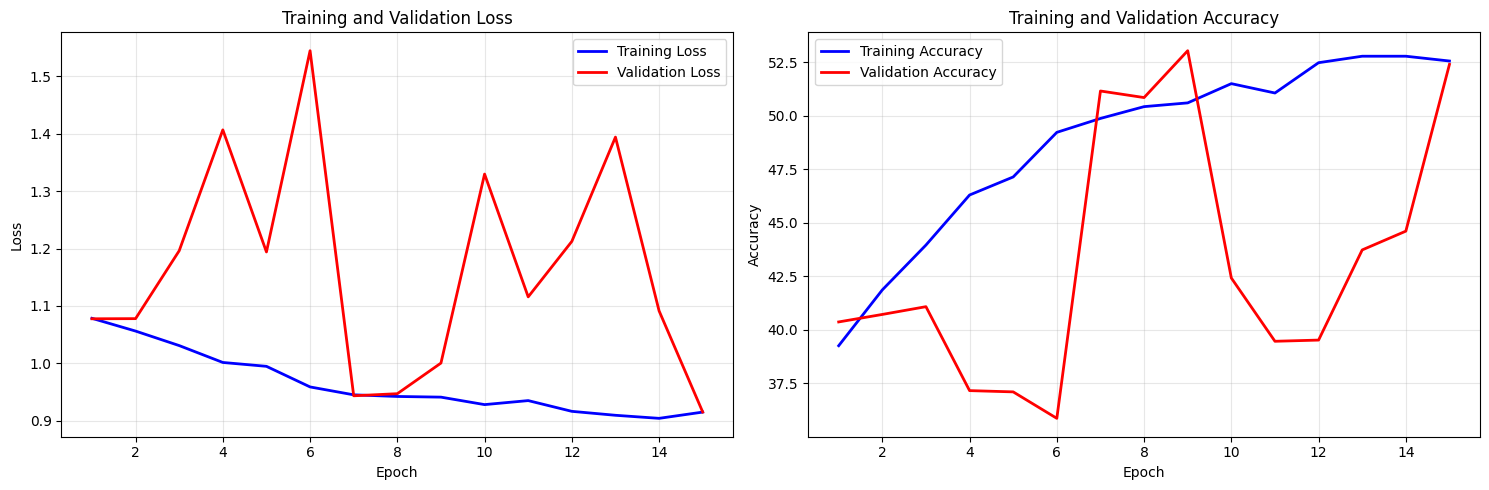

In [159]:
# plot both accuracy and loss

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

# plot losses 
ax1.plot(range(1, epochs + 1), trainLosses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(range(1, epochs + 1), validationLosses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot accuracies 
ax2.plot(range(1, epochs + 1), trainAccuracies, 'b-', label='Training Accuracy', linewidth=2)
ax2.plot(range(1, epochs + 1), validationAccuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout() 
plt.show() 

In [160]:
# Model evaluation on the 10% of the remaining data from the dataset 

print("Evaluating on test set...")

# load the best model obtained during the training & validation preparation 
model_0.load_state_dict(torch.load('best_uhi_model.pth')) 
test_loss, test_metrics = validation_step(model = model_0, 
                                          dataloader = test_dataloader, 
                                          loss_fn = loss_fn, 
                                          device = device)
print(f"\nTest Results")
print(f"Test Loss: {test_loss: .4f} | Test accuracy: {test_metrics['accuracy']: .4f}")

print(f"Detailed per class metrics:")
class_names = ['Cold', 'Moderate', 'Hot']
for class_id in range(3):
    print(f"\n{class_names[class_id]} Class:")
    print(f"  Precision: {test_metrics[f'precision_class_{class_id}']:.4f}")
    print(f"  Recall: {test_metrics[f'recall_class_{class_id}']:.4f}")
    print(f"  F1-Score: {test_metrics[f'f1_class_{class_id}']:.4f}")


Evaluating on test set...


Validation:   0%|          | 0/13 [00:00<?, ?it/s]


Test Results
Test Loss:  0.8704 | Test accuracy:  55.4473
Detailed per class metrics:

Cold Class:
  Precision: 0.4943
  Recall: 0.6048
  F1-Score: 0.5440

Moderate Class:
  Precision: 0.6875
  Recall: 0.3151
  F1-Score: 0.4321

Hot Class:
  Precision: 0.5417
  Recall: 0.8568
  F1-Score: 0.6638


In [161]:
# define a function to extract the patches 
from typing import Tuple, List
def extract_patches_reconstruction(image: np.ndarray, patch_size: int = 64, step: int = 32) -> Tuple[np.ndarray, List[Tuple[int, int]]]: 
    """Takes an image and splits it into mutiple patches, returns a tuple of the patches and the positions 
    for each patch."""
    _, height, width = image.shape
    patches = []
    positions = []

    # loop through patches like in a matrix
    for i in range(0, height - patch_size + 1, step): 
        for j in range(0, width - patch_size + 1, step): 
            patch = image[:, i:i + patch_size, j:j + patch_size]
            patches.append(patch)
            positions.append((i,j))
    
    return np.array(patches), positions 
  

In [162]:
def reconstruct_with_uncertainty(patches_tensor: torch.Tensor, 
                                 model: torch.nn.Module, 
                                 positions: list[Tuple[int, int]], 
                                 original_shape, 
                                 patch_size: Tuple[int, int]): 
    
    C, H, W = original_shape

    # initialize output maps 
    uhi_sum = np.zeros((3, H, W))
    weight_map = np.zeros((H, W))
    uncertainty_map = np.zeros((H,W))

    model.eval()

    # multiple forward passes for uncertainty estimation 
    n_monte_carlo = 5 
    all_predictions = []

    for iteration in range(n_monte_carlo): 
        model.train() #enable the dropout for monte carlo sampling (randomness + repetition = certainty)
        predictions_monte_carlo = [] 

        with torch.no_grad(): 
            for patch in patches_tensor: 
                patch = patch.unsqueeze(0).to(device)
                logits = model(patch)
                probabilities = torch.nn.functional.softmax(logits, dim = 1).squeeze(0).numpy()
                predictions_monte_carlo.append(probabilities)

        all_predictions.append(predictions_monte_carlo)

    # calculate mean and uncertainty 
    all_predictions = np.array(all_predictions) # shape (n_monte_carlo, patches, num_classes, height, width)
    mean_predictions = np.mean(all_predictions, axis = 0) # do the mean on the n_monte_carlo times 
    std_predictions = np.std(all_predictions, axis = 0)

    # reconstruct full image 
    for index, (i, j) in enumerate(positions): 
        # if index >= len(mean_predictions): # do not access something outside the predictions 
        #     continue 

        pred_probs = mean_predictions[index]
        pred_uncertainty = np.mean(std_predictions[index], axis = 0)

        # ensure we do not go out the bounds 
        end_i = min(i + patch_size, H)
        end_j = min(j + patch_size, W)
        patch_h = end_i - i
        patch_w = end_j - j


        # add the predictions to the map 
        uhi_sum[:, i : end_i, j : end_j] += pred_probs[:, :patch_h, :patch_w]
        weight_map[i:end_i, j:end_j] += 1
        uncertainty_map[i : end_i, j : end_j] += pred_uncertainty[:patch_h, :patch_w]        

    # normalize by weights 
    weight_map[weight_map == 0] = 1 # avoid the division by zero 
    uhi_probs = uhi_sum / weight_map[None, :, :]
    uncertainty_map = uncertainty_map / weight_map

    # final classification and confidence 
    final_classification = np.argmax(uhi_probs, axis = 0)
    confidence_map = np.max(uhi_probs, axis = 0)

    return final_classification, confidence_map, uncertainty_map


In [163]:
from matplotlib.colors import ListedColormap
def visualization(original_image, uhi_map, confidence_map, uncertainty_map): 
    fig = plt.figure(figsize = (20,16))

    colors_uhi = ['Blue', 'Yellow', 'Red' ]
    cmap_uhi = ListedColormap(colors_uhi)

    # remember the configuration for the bands, 0 - indexed
    # ('Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'LST_C', 'NDVI', 'NDBI', 'MNDWI')

    # original rgb
    ax1 = plt.subplot(3, 3, 1)
    red = original_image[2]
    green = original_image[1]
    blue = original_image[0]

    rgb = np.stack([red, green, blue], axis = -1)
    
    # normalize for display 
    rgb_norm = np.clip((rgb - rgb.min()) / (rgb.max() - rgb.min()), 0, 1) # makes all values inside the array to be in [0,1] interval 
    ax1.imshow(rgb_norm)
    ax1.set_title("Original RGB", fontsize = 14, fontweight = 'bold')
    ax1.axis('off')

    # land surface temperature -> we'll place it top center -
    ax2 = plt.subplot(3, 3, 2)
    lst = original_image[6]
    print("LST raw values:", lst.min(), lst.max(), lst.mean())

    image2 = ax2.imshow(lst)
    plt.colorbar(image2, ax = ax2, label = "Temperature in degrees celsius")
    ax2.set_title("Land Surface Temperature", fontsize = 14, fontweight = 'bold')
    ax2.axis('off')

    # ndvi -> top right 
    ax3 = plt.subplot(3, 3 ,3)
    ndvi = original_image[7]
    image3 = ax3.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(image3, ax=ax3, shrink=0.6, label='NDVI')
    ax3.set_title('Normalized Difference Vegetation Index', fontsize=14, fontweight='bold')

    # uhi classification 
    ax4 = plt.subplot(3, 3, 4)
    image4 = ax4.imshow(uhi_map, cmap = cmap_uhi, vmin = 0, vmax = 2)
    bar4 = plt.colorbar(image4, ax = ax4, ticks = [0,1,2])
    bar4.set_ticklabels(['Cold', 'Moderate', 'Hot'])
    bar4.set_label('UHI Classification')
    ax4.set_title('Urban Heat Island Classification', fontsize = 14, fontweight = 'bold')
    ax4.axis('off')

    # Confidence map 
    ax6 = plt.subplot(3, 3, 5)
    image6 = ax6.imshow(confidence_map, cmap = 'viridis', vmin = 0, vmax = 1)
    plt.colorbar(image6, ax = ax6, label = 'Confidence')
    ax6.set_title('Confidence Classification', fontsize = 14, fontweight = 'bold')
    ax6.axis('off')

    # uncertainty map
    ax7 = plt.subplot(3,3,6)
    image7 = ax7.imshow(uncertainty_map, cmap = 'plasma')
    plt.colorbar(image7, ax = ax7, label = 'Uncertainty')
    ax7.set_title('Prediction Uncertainty', fontsize = 14, fontweight = 'bold')
    ax7.axis('off')

In [164]:
def process_full_image(image_path, model, save_visualization=False):
    """Process a full satellite image and create UHI map"""
    
    print(f"Processing {image_path}...")
    
    # load the image
    try:
        with rasterio.open(image_path) as src:
            full_image = src.read()
        print(f"Image loaded with shape: {full_image.shape}")
    except Exception as e:
        print(f"Error loading image: {e}")
        return None
    
    # clean the data
    full_image_clean = np.nan_to_num(full_image, nan=0.0)
    
    # extract patches for reconstruction
    patches, positions = extract_patches_reconstruction(
        full_image_clean, patch_size=64, step=32
    )
    
    print(f"Extracted {len(patches)} patches for reconstruction")
    
    # convert to tensor
    patches_tensor = torch.from_numpy(patches).float()
    
    # reconstruct with uncertainty
    uhi_classification, confidence, uncertainty = reconstruct_with_uncertainty(
        patches_tensor, model, positions, full_image.shape, patch_size=64
    )
    
    print("Reconstruction completed")
    
    # create visualization
    if save_visualization:
        timestamp = image_path.split('_')[-1].split('.')[0] if '_' in image_path else 'unknown'
        save_path = f'uhi_analysis_{timestamp}.png'
        
        fig = visualization(
            full_image_clean, uhi_classification, confidence, uncertainty, save_path
        )
    else:
        fig = visualization(
            full_image_clean, uhi_classification, confidence, uncertainty
        )
    
    return uhi_classification, confidence, uncertainty, fig

Processing sample image for visualization
Processing assets/features_20250602.tif...
Image loaded with shape: (13, 667, 666)
Extracted 361 patches for reconstruction
Reconstruction completed
LST raw values: 0.0 1.463915 0.12068125822786807
Sample processing completed successfully!


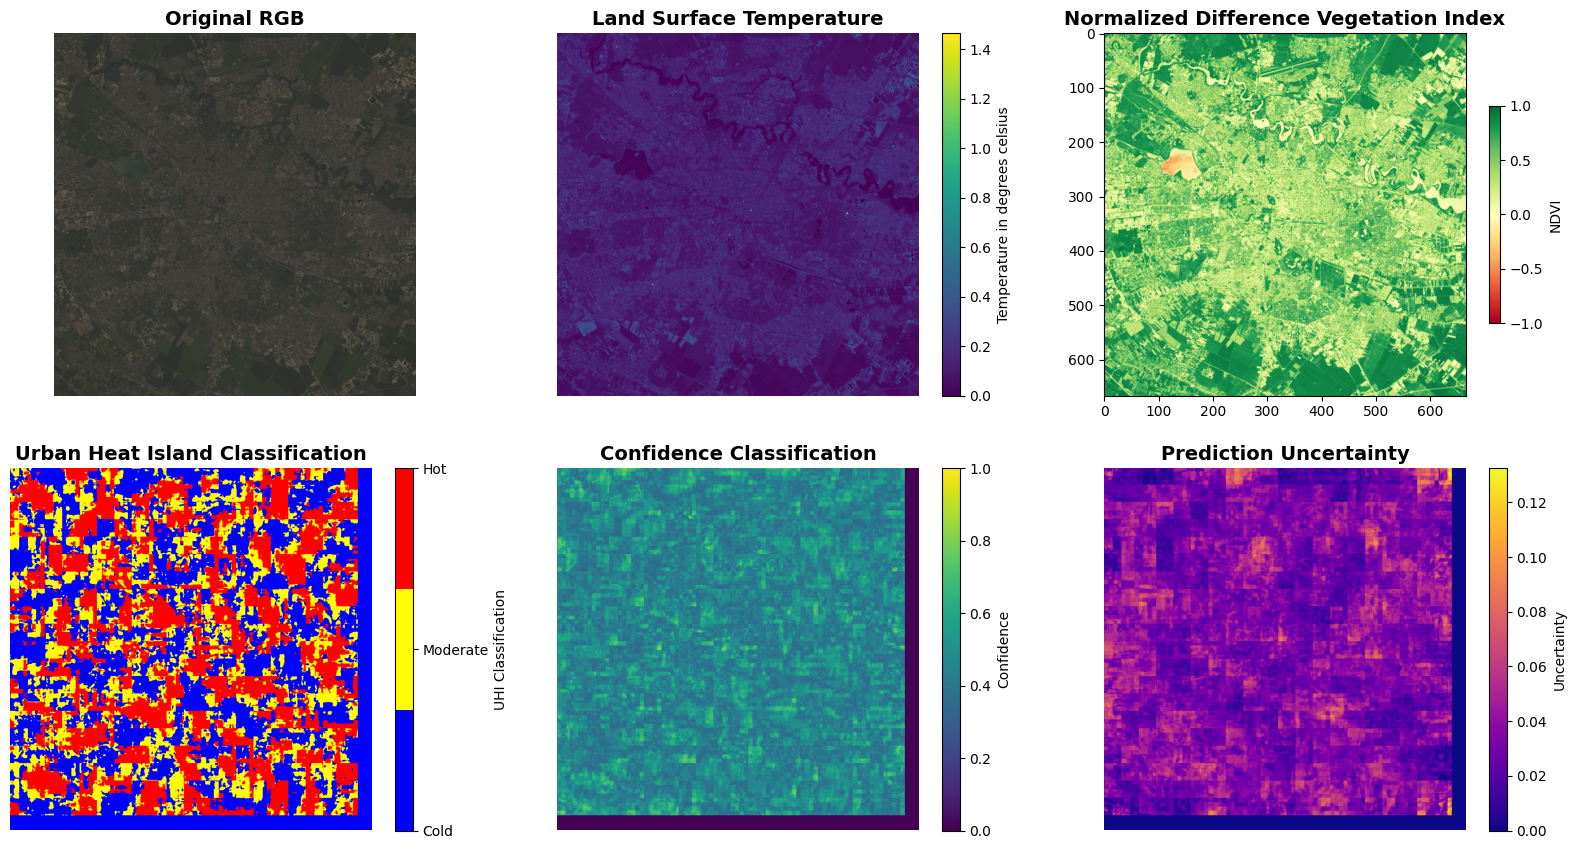

In [165]:
if images: 
    print('Processing sample image for visualization')

    sample_image = images[0]
    result = process_full_image(sample_image, model_0, False)
    if result is not None: 
        print("Sample processing completed successfully!")
else: 
    print("Error while trying to process sample!")

In [166]:
# set up device agnostic code 
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# load pre-trained model 
try:
    # create model instance with same architecture
    model_loaded = UHINet(input_shape=13, output_shape=3, hidden_units=32).to(device)
    
    # load the trained weights
    model_loaded.load_state_dict(torch.load('best_uhi_model.pth', map_location=device))
    model_loaded.eval()
    
    print("Model loaded successfully from 'best_uhi_model.pth'!")
    
except FileNotFoundError:
    print("File 'best_uhi_model.pth' not found!")
    print("Make sure you've trained the model first")
    model_loaded = None
except Exception as e:
    print(f"Error loading model: {e}")
    model_loaded = None

Model loaded successfully from 'best_uhi_model.pth'!


In [ ]:
import folium
from folium import plugins
import rasterio
from rasterio.warp import transform_bounds
import base64
from io import BytesIO
from PIL import Image
import numpy as np
import torch

# patch extraction 
def extract_patches_with_edges(image: np.ndarray, patch_size: int = 64, step: int = 32):
    """Extract patches ensuring full coverage including edges"""
    C, H, W = image.shape
    patches = []
    positions = []
    
    # calculate ranges to ensure full coverage
    i_positions = list(range(0, H - patch_size + 1, step))
    j_positions = list(range(0, W - patch_size + 1, step))
    
    # add final positions to ensure edge coverage
    if i_positions[-1] + patch_size < H:
        i_positions.append(H - patch_size)
    if j_positions[-1] + patch_size < W:
        j_positions.append(W - patch_size)
    
    # extracting patches 
    for i in i_positions:
        for j in j_positions:
            # ensure we don't go out of bounds
            end_i = min(i + patch_size, H)
            end_j = min(j + patch_size, W)
            
            # extract patch
            patch = image[:, i:end_i, j:end_j]
            
            # pad patch if needed (for edge cases)
            if patch.shape[1] < patch_size or patch.shape[2] < patch_size:
                padded_patch = np.zeros((C, patch_size, patch_size), dtype=patch.dtype)
                padded_patch[:, :patch.shape[1], :patch.shape[2]] = patch
                patch = padded_patch
            
            patches.append(patch)
            positions.append((i, j))
    
    print(f"Extracted {len(patches)} patches")
    return np.array(patches), positions

from scipy.ndimage import distance_transform_edt

def reconstruct_uhi(patches_tensor, model, positions, original_shape, patch_size=64):
    """Reconstruction with proper edge handling and overlap management"""
    _, H, W = original_shape
    
    print(f"Reconstructing to shape: {H} x {W}")
    
    # Initialize maps
    uhi_sum = np.zeros((3, H, W), dtype=np.float32)
    weight_map = np.zeros((H, W), dtype=np.float32)
    
    model.eval()
    
    with torch.no_grad():
        for idx, patch in enumerate(patches_tensor):
            if idx % 50 == 0:
                print(f"   Processing patch {idx+1}/{len(patches_tensor)}")
            
            patch = patch.unsqueeze(0).to(device)
            
            # do a forward pass
            y_logits = model(patch)
            y_probs = torch.softmax(y_logits, dim=1).squeeze(0).cpu().numpy()
            
            # get position
            if idx < len(positions):
                i, j = positions[idx]
                
                # calculate actual patch dimensions in output
                pred_h, pred_w = y_probs.shape[1], y_probs.shape[2]
                
                # calculate how much of the prediction to use
                end_i = min(i + pred_h, H)
                end_j = min(j + pred_w, W)
                
                # calculate dimensions to copy
                copy_h = end_i - i
                copy_w = end_j - j
                
                # add to sum maps
                uhi_sum[:, i:end_i, j:end_j] += y_probs[:, :copy_h, :copy_w]
                weight_map[i:end_i, j:end_j] += 1.0
    
    # normalize by weights
    weight_map[weight_map == 0] = 1.0
    uhi_probs = uhi_sum / weight_map[None, :, :]
    
    # get final classification and confidence
    final_classification = np.argmax(uhi_probs, axis=0)
    confidence_map = np.max(uhi_probs, axis=0)
    
    # fill any remaining zero areas using nearest neighbor
    zero_mask = weight_map == 1.0  # pixels that were originally zero
    if np.any(zero_mask):
        print(f"Filling {np.sum(zero_mask)} edge pixels using nearest neighbor")
        
        valid_mask = ~zero_mask
        distance, indices = distance_transform_edt(zero_mask, return_indices=True)
        
        final_classification[zero_mask] = final_classification[tuple(indices[:, zero_mask])]
        confidence_map[zero_mask] = confidence_map[tuple(indices[:, zero_mask])] * 0.5  # lower confidence
   
    return final_classification, confidence_map

# georeferencing functions 
def get_real_bounds_from_tiff(tiff_path):
    """Extract real geographic bounds from TIFF file"""
    try:
        with rasterio.open(tiff_path) as src:
            # get bounds in the source CRS
            bounds = src.bounds  # (left, bottom, right, top)
            source_crs = src.crs
                        
            # transform to WGS84 (lat/lon) if needed
            if source_crs != 'EPSG:4326':
                # transform bounds to WGS84
                left, bottom, right, top = transform_bounds(
                    source_crs, 'EPSG:4326', bounds.left, bounds.bottom, bounds.right, bounds.top
                )
            else:
                left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
            
            # return in Folium format: [[south, west], [north, east]]
            folium_bounds = [[bottom, left], [top, right]]
        
            return folium_bounds, (left, bottom, right, top)
            
    except Exception as e:
        print(f"Error getting bounds from TIFF: {e}")
        print("Using default Bucharest bounds")

        # default Bucharest bounds if extraction fails
        return [[44.35, 26.00], [44.51, 26.20]], (26.00, 44.35, 26.20, 44.51)


def create_georeferenced_overlay(array, output_bounds, colormap_type='categorical'):
    """Create properly georeferenced overlay"""
    try:
        if colormap_type == 'categorical':
            # UHI classification colors
            colors = [(0, 102, 204), (255, 255, 102), (204, 0, 0)]  # blue, yellow, red
            
            # create RGBA image
            height, width = array.shape
            rgba_img = np.zeros((height, width, 4), dtype=np.uint8)
            
            for class_id, color in enumerate(colors):
                mask = (array == class_id)
                rgba_img[mask] = list(color) + [200]  # slightly more opaque
            
            # set transparent for no-data
            no_data_mask = (array < 0) | (array > 2)
            rgba_img[no_data_mask] = [0, 0, 0, 0]
            
        else:  # continuous
            # normalize array
            array_norm = (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))
            array_norm = np.clip(array_norm, 0, 1)
            
            # apply colormap
            import matplotlib.pyplot as plt
            cmap = plt.cm.viridis if colormap_type == 'confidence' else plt.cm.RdYlBu_r
            rgba_img = (cmap(array_norm) * 255).astype(np.uint8)
        
        # convert to PIL Image
        img = Image.fromarray(rgba_img, mode='RGBA')
        
        # resize if too large (for better web performance)
        max_size = 2048
        if max(img.size) > max_size:
            ratio = max_size / max(img.size)
            new_size = (int(img.size[0] * ratio), int(img.size[1] * ratio))
            img = img.resize(new_size, Image.Resampling.LANCZOS)
            print(f"Resized image to {new_size} for better performance")
        
        # convert to base64
        buffer = BytesIO()
        img.save(buffer, format='PNG', optimize=True)
        buffer.seek(0)
        img_base64 = base64.b64encode(buffer.read()).decode()
        
        return f"data:image/png;base64,{img_base64}"
        
    except Exception as e:
        print(f"Error creating georeferenced overlay: {e}")
        return None

def process_image_with_proper_georef(feature_path, model, device='cpu'):
    """Process image with proper georeferencing and edge handling"""
     
    # load image and get real bounds
    try:
        with rasterio.open(feature_path) as src:
            full_image = src.read()
            
        folium_bounds, bbox = get_real_bounds_from_tiff(feature_path)
        print(f"Image loaded: {full_image.shape}")
        
    except Exception as e:
        print(f"Error loading image: {e}")
        return None, None, None, None
    
    # Clean data
    full_image_clean = np.nan_to_num(full_image, nan=0.0)
    
    # extract_patches
    patches, positions = extract_patches_with_edges(
        full_image_clean, patch_size=64, step=32
    )
    
    # convert to tensor
    patches_tensor = torch.from_numpy(patches).float()
    
    # reconstruct
    uhi_classification, confidence = reconstruct_uhi(
        patches_tensor, model, positions, full_image.shape
    )
    
    # get temperature data if available
    temp_map = None
    if full_image.shape[0] > 6:
        temp_map = full_image[3]  # LST_C band
    
    return uhi_classification, confidence, temp_map, folium_bounds

# folium map creation 
def create_properly_georeferenced_map(feature_path, model, save_path='properly_georef_uhi_map.html'):
    """Create properly georeferenced UHI map"""

    # Process image with proper georeferencing
    uhi_map, confidence_map, temp_map, bounds = process_image_with_proper_georef(
        feature_path, model, device
    )
    
    if uhi_map is None:
        print("Failed to process image")
        return None
    
    # calculate map center from bounds
    center_lat = (bounds[0][0] + bounds[1][0]) / 2
    center_lon = (bounds[0][1] + bounds[1][1]) / 2
    
    # create map
    m = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # add satellite base layer
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Esri WorldImagery',
        name='Satellite',
        control=True
    ).add_to(m)
    
    # create and add UHI overlay with proper bounds
    uhi_overlay = create_georeferenced_overlay(uhi_map, bounds, 'categorical')
    if uhi_overlay:
        folium.raster_layers.ImageOverlay(
            image=uhi_overlay,
            bounds=bounds,  # Use real geographic bounds
            name="UHI Classification",
            opacity=0.8,
            interactive=True
        ).add_to(m)
    
    # add confidence overlay if available
    if confidence_map is not None:
        conf_overlay = create_georeferenced_overlay(confidence_map, bounds, 'confidence')
        if conf_overlay:
            folium.raster_layers.ImageOverlay(
                image=conf_overlay,
                bounds=bounds,
                name="Classification Confidence",
                opacity=0.6,
                show=False
            ).add_to(m)
    
    # add temperature overlay if available
    if temp_map is not None:
        temp_overlay = create_georeferenced_overlay(temp_map, bounds, 'temperature')
        if temp_overlay:
            folium.raster_layers.ImageOverlay(
                image=temp_overlay,
                bounds=bounds,
                name="Land Surface Temperature", 
                opacity=0.7,
                show=False
            ).add_to(m)
    
    # Add enhanced legend
    legend_html = '''
    <div style="position: fixed; bottom: 50px; left: 50px; width: 180px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px; border-radius: 5px; box-shadow: 0 0 10px rgba(0,0,0,0.3);">
    <p style="margin: 0; font-weight: bold;">🌡️ UHI Classification</p>
    <p style="margin: 3px 0;"><span style="color:#0066CC; font-size:18px;">●</span> Cold Areas</p>
    <p style="margin: 3px 0;"><span style="color:#FFFF66; font-size:18px;">●</span> Moderate UHI</p>
    <p style="margin: 3px 0;"><span style="color:#CC0000; font-size:18px;">●</span> Hot UHI</p>
    <hr style="margin: 8px 0;">
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # add controls and tools
    folium.LayerControl(collapsed=False).add_to(m)
    plugins.Fullscreen().add_to(m)
    plugins.MeasureControl(
        primary_length_unit='kilometers',
        secondary_length_unit='meters'
    ).add_to(m)
    
    # add a marker at the center for reference
    folium.Marker(
        [center_lat, center_lon],
        popup=f"Image Center<br>Lat: {center_lat:.4f}<br>Lon: {center_lon:.4f}",
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(m)
    
    # Save map
    m.save(save_path)
    
    return m, uhi_map, confidence_map

In [169]:
if model_loaded is not None:
    # Use the enhanced function
    enhanced_map, uhi_result, conf_result = create_properly_georeferenced_map(
        feature_path='assets/features_20250713.tif',
        model=model_loaded,
        save_path='georef_uhi_map.html'
    )
    
    if enhanced_map is not None:
        print("map created!")
    else:
        print("visualization failed")
else:
    print("Load model first!")


Image loaded: (13, 667, 666)
Extracted 400 patches
Reconstructing to shape: 667 x 666
   Processing patch 1/400
   Processing patch 51/400
   Processing patch 101/400
   Processing patch 151/400
   Processing patch 201/400
   Processing patch 251/400
   Processing patch 301/400
   Processing patch 351/400
Filling 3422 edge pixels using nearest neighbor


ValueError: too many values to unpack (expected 3)